# Landmark-based Fingerprinting

This practical uses the audio fingerprinting code from https://github.com/dpwe/audfprint .
You should download it as a directory `audfprint/` into the same directory as this notebook file.

This fingerprint, based on the description in [Avery Wang's paper](https://www.ee.columbia.edu/~dpwe/papers/Wang03-shazam.pdf), arranges local peaks in the spectrogram into pairs, then builds an index mapping hashes based on the frequencies and time spacing of the pairs to every track that contains them.  A good match is found when multiple 
common hashes have the same relative timing in query and reference.

In [1]:
%pylab inline
from __future__ import print_function
import cPickle as pickle
import os
import IPython

import numpy as np

import librosa

#os.chdir('/Users/dpwe/Downloads/e4896/elene4896/prac12')
from audfprint import audfprint_analyze
from audfprint import audfprint_match
from audfprint import hash_table
from audfprint import audio_read


Populating the interactive namespace from numpy and matplotlib


In [2]:
def read_list_file(filename):
    """Read a text file with one item per line."""
    items = []
    with open(filename, 'r') as f:
        for line in f:
            items.append(line.strip())
    return items

def my_imshow(data, **kwargs):
    """Wrapper for imshow that sets common defaults."""
    plt.imshow(data, interpolation='nearest', aspect='auto', 
               origin='bottom', cmap='gray_r', **kwargs)

In [3]:
# Read in a local query file.
# You can download these files at http://www.ee.columbia.edu/~dpwe/e4896/code/prac12/01-Taxman.mp3
# and http://www.ee.columbia.edu/~dpwe/e4896/code/prac12/Come_Together.mp3
filename = '01-Taxman.mp3'
#filename = 'Come_Together.mp3'
y, sr = librosa.load(filename, sr=None)
print("sr=", sr, "y.shape=", y.shape)

sr= 16000 y.shape= (2545920,)


In [4]:
# The Analyzer object manages the creation of landmark hashes for the query.
analyzer = audfprint_analyze.Analyzer()
analyzer.target_sr = sr
analyzer.density = 10   # Target number of hashes per second.
peaks = analyzer.find_peaks(y, sr)
print("len(peaks)=", len(peaks))
print(peaks[:5])
frame_hop = 256   # Analyzer always uses 512 point FFTs with 256 point advance.
frame_rate = sr / float(frame_hop)
print("frame_rate=", frame_rate, "Hz")

len(peaks)= 1201
[(65, 3), (65, 26), (66, 78), (66, 80), (66, 89)]
frame_rate= 62.5 Hz


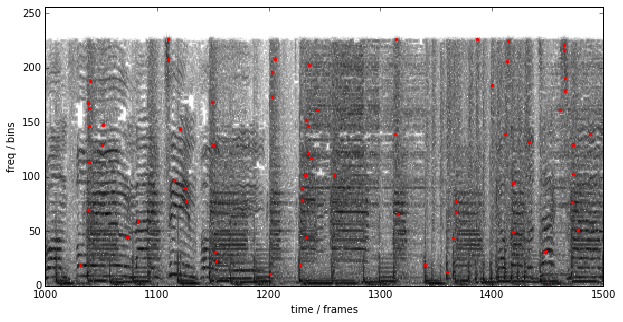

In [5]:
# Plot the peaks that were found over the equivalent spectrogram.
sgram = np.abs(librosa.stft(y, n_fft=512, hop_length=256))
plt.figure(figsize=(10,5))
my_imshow(20*np.log10(np.maximum(1e-3, sgram)))
peaks = np.array(peaks)
plot(peaks[:, 0], peaks[:, 1], '.r')
xlim([1000, 1500])
ylim([0, 256])
xlabel("time / frames")
ylabel("freq / bins")

len(landmarks)= 1805
   t0  f1  f2  dt
[[ 65  26  42  26]
 [ 66  78  60  37]
 [ 66  78  84  37]
 [ 66  78  67  38]
 [ 66  80 109  36]]


(0, 256)

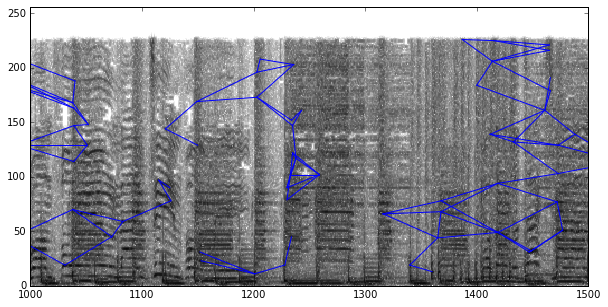

In [6]:
# Convert the individual peaks into landmark pairs by finding 
# nearby instances.
landmarks = np.array(analyzer.peaks2landmarks(peaks))
print("len(landmarks)=", len(landmarks))
# Each row of landmarks contains the start time bin, the start and end frequency bins, and the time separation.
print("   t0  f1  f2  dt")
print(landmarks[:5])
t0 = landmarks[:, 0]
f1 = landmarks[:, 1]
f2 = landmarks[:, 2]
dt = landmarks[:, 3]
# Plot the pairs over the spectrogram.
plt.figure(figsize=(10,5))
my_imshow(20*np.log10(np.maximum(1e-3, sgram)))
plot([t0, t0+dt], [f1, f2], '-b')
plot([t0, t0+dt], '.b')
xlim([1000, 1500])
ylim([0, 256])

In [7]:
# To look up in the database, each (f1, f2, dt) triple is converted into a 20-bit binary number.
hashes = audfprint_analyze.landmarks2hashes(landmarks)
print("len(hashes)=", len(hashes))
print("time  hash")
print(hashes[:5])

len(hashes)= 1805
time  hash
[(65, 107546), (66, 322469), (66, 319909), (66, 322918), (66, 329572)]


(0, 256)

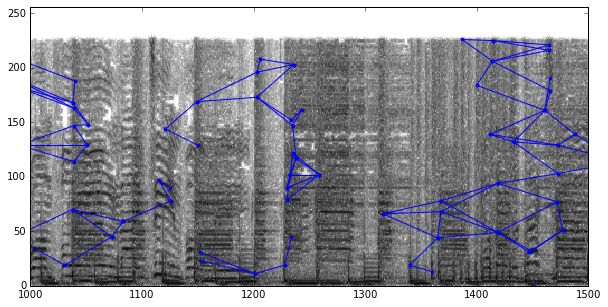

In [8]:
# We can still convert the hashes back into the (f1, f2, dt) triples and plot them on the spectrogram.
def show_hashes(hashes, d=None, sr=None, color='b'):
    """Plot the hashes on a spectrogram."""
    if d is not None:
        sgram = np.abs(librosa.stft(d, n_fft=512, hop_length=256))
        my_imshow(20*np.log10(np.maximum(1e-3, sgram)))
    landmarks = np.array(audfprint_analyze.hashes2landmarks(hashes))
    t0 = landmarks[:, 0]
    f1 = landmarks[:, 1]
    f2 = landmarks[:, 2]
    dt = landmarks[:, 3]
    plot([t0, t0 + dt], [f1, f2], '-' + color)
    plot([t0, t0 + dt], [f1, f2], '.' + color)

plt.figure(figsize=(10,5))
show_hashes(hashes, y, sr)
xlim([1000, 1500])
ylim([0, 256])

# Reference Database

`audfprint` will take a list of audio files and build a big database from all their hashes.
I precomputed one from the 32 kbps MP3 versions of the 8752 tracks that comprise
[uspop2002](http://labrosa.ee.columbia.edu/projects/musicsim/uspop2002.html).  For 
reference, the exact command is below.  I ran it on parallel on 8 cores and it took 
about 20 minutes to ingest all the files.

```
porkpie:/scratch/dpwe > time python ~/projects/audfprint/python/audfprint.py new -d uspop-n10-b20.fpdb -W ~drspeech/data/music/mp3s-32k -V .mp3 -r 16000 -l ~drspeech/data/music/mp3s-mp3s.txt -H 8 -n 10 -b 20
hash_table 0 has 1094 files 2616250 hashes
hash_table 1 has 1094 files 2654923 hashes
hash_table 2 has 1094 files 2636462 hashes
hash_table 3 has 1094 files 2710421 hashes
hash_table 4 has 1094 files 2620202 hashes
hash_table 5 has 1094 files 2692489 hashes
hash_table 6 has 1094 files 2647007 hashes
hash_table 7 has 1094 files 2643872 hashes
Saved fprints for 8752 files ( 21151809 hashes) to uspop-n10-b20.fpdb
Dropped hashes= 6571527 (31.07%)
16653.208u 1197.230s 37:32.89 792.3%    0+0k 0+109080io 0pf+0w
```

You can download the database as [uspop-n10-b20.fpdb](http://www.ee.columbia.edu/~dpwe/e4896/code/prac12/uspop-n10-b20.fpdb) (55 MB).

In [9]:
# Read in the precomputed fingerprint database.
# Hack to allow loading of pickled class when audfprint used as module.
sys.modules['hash_table'] = hash_table
# To keep it small, the database was built with density 10 hashes/sec (-n 10) 
# and a maximum of 20 entries per hash (-b 20).
database_file = 'uspop-n10-b20.fpdb'
database = hash_table.HashTable(filename=database_file)

Read fprints for 8752 files ( 21151809 hashes) from uspop-n10-b20.fpdb


In [10]:
# This database has full paths for the names.  Define a function to return a shorter name.
def track_name(database, index):
    return database.names[index][49:-4]

In [11]:
# Main contents of hash table is database.table, which holds track/time values
# for occurrence of each hash.  Show the content for one bin from the original 
# query track.  The bottom 14 bits of each entry hold the time offset, and the 
# top 18 bits (i.e. value/16384) hold the track index.
hash_number = 120
print('\n'.join([track_name(database, i) for i in database.table[hashes[hash_number][1]] / 16384 if i > 0]))
print(database.table[hashes[hash_number][1]] % 16384)

paul_van_dyk/Out_There_and_Back/12-We_Are_Alive
deftones/Around_The_Fur/10-Mx
elvis_costello/King_Of_America/16-The_People_s_Limousine
fine_young_cannibals/The_Raw_The_Cooked/02-Good_Thing
montell_jordan/This_Is_How_We_Do_It/03-This_Is_How_We_Do_It
our_lady_peace/Clumsy/05-4am
spandau_ballet/True/04-Gold
everlast/Eat_At_Whitey_s/05-Babylon_Feeling_Featuring_Carlos_Santana_
sisqo/Unleash_The_Dragon/13-Your_Are_Everthing_Remix_by_Dru_Hill_Feat_Ja_Rule_
wheatus/Wheatus/06-Leroy
foo_fighters/The_Colour_And_The_Shape/04-My_Poor_Brain
pennywise/Straight_Ahead/12-Just_For_You
ani_difranco/Dilate/02-Outta_Me_Onto_You
nirvana/MTV_Unplugged_In_New_York/13-All_Apologies
foo_fighters/There_Is_Nothing_Left_To_Lose/01-Stacked_Actors
verve/Urban_Hymns/02-Sonnet
[15764 10331  1682  9630 15544 12933 15410  5241  2332  3141   373  6365
  8496  1150   727  4965     0     0     0     0]


In [13]:
# The Matcher object manages matching a query track against a database.
matcher = audfprint_match.Matcher()
results = matcher.match_hashes(database, hashes)
# Rows in results are [id, filt_count, time_skew, raw_count, orig_rank, min_time, max_time].
print("  id #match t_skew #raw")
print(results[:, :4])
print("name for id", results[0, 0], "is", track_name(database, results[0, 0]))

  id #match t_skew #raw
[[ 6653   231     8   277]
 [ 6653     6 -4528   277]]
name for id 6653 is beatles/Revolver/01-Taxman


hits.shape= (33624, 4)
     id  t_skew  hash  t_query
[[  5745   9846 107546     65]
 [  4336   5153 107546     65]
 [  6970   4402 107546     65]
 [  7325   5499 107546     65]
 [  6521   6504 107546     65]]
Most common id= 6653 with #hits= 277
#hits for result # 0 (id 6653 )= 277
matching_hashes.shape= (231, 2)
 t_query   hash
[[ 5565 21246]
 [ 5565 22037]
 [ 5565 24318]
 [ 2778 24950]
 [ 4894 24989]]


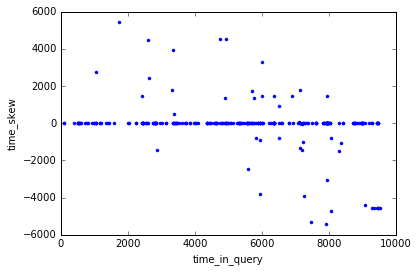

In [18]:
# We can actually break down what match_hashes does to get a little more insight.
# First, return all the hits from the database entries for the hashes present in the query.
hits = database.get_hits(hashes)
# hits has one row per hash hit with columns [id time_skew_ref_query hash time_in_query]
print("hits.shape=", hits.shape)
print("     id  t_skew  hash  t_query")
print(hits[:5])
print("Most common id=", np.argmax(np.bincount(hits[:, 0])), "with #hits=", np.max(np.bincount(hits[:, 0])))
result_rank = 0
top_result_id = results[result_rank, 0]
top_result_t_skew = results[result_rank, 2]
match_hits = np.nonzero(hits[:, 0] == top_result_id)[0]
print("#hits for result #", result_rank, "(id", top_result_id, ")=", len(match_hits))
plot(hits[match_hits, 3], hits[match_hits, 1], '.')
#xlim([8000, 10000])
#ylim([-100, 0])
xlabel('time_in_query')
ylabel('time_skew')
matching_hashes = matcher._unique_match_hashes(top_result_id, hits, top_result_t_skew)
# Matching hashes are returned as (time_in_query, hash) rows.
print("matching_hashes.shape=", matching_hashes.shape)
print(" t_query   hash")
print(matching_hashes[:5])

(0, 256)

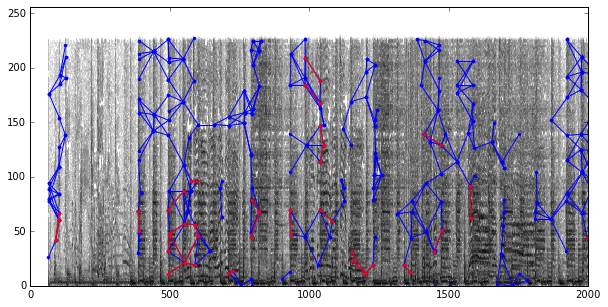

In [19]:
# Plot all the query hashes, then overplot the matching ones in red.
plt.figure(figsize=(10,5))
show_hashes(hashes, y, sr)
show_hashes(matching_hashes, color='r')
xlim([0, 2000])
ylim([0, 256])

In [20]:
# We can get the reference item audio via the lab's web server.
URL_BASE = 'http://labrosa.ee.columbia.edu:8013/uspop'
url = URL_BASE + '/' + '/'.join(database.names[results[0, 0]].split('/')[-3:])
print(url)
IPython.display.Audio(url=url)

http://labrosa.ee.columbia.edu:8013/uspop/beatles/Revolver/01-Taxman.mp3


In [21]:
# And we can read the mp3 file at a URL into the workspace as a waveform.
import urllib2
import tempfile

def read_mp3_from_url(url, sr=None):
    """Read a soundfile from a URL."""
    response = urllib2.urlopen(url)
    mp3data = response.read()
    response.close()
    handle = tempfile.NamedTemporaryFile(delete=False)
    handle.write(mp3data)
    handle.close()
    y, sr = librosa.load(handle.name, sr=sr)
    os.remove(handle.name)
    return y, sr

r_y, sr = read_mp3_from_url(url)
print(sr, r_y.shape)

16000 (2545344,)


In [22]:
frame_start = 9300
frame_end = 9700
frame_skew = -4536
data=np.vstack([r_y[int(frame_start/frame_rate*sr):int(frame_end/frame_rate*sr)][np.newaxis, :],
                r_y[int((frame_start + frame_skew)/frame_rate*sr):
                    int((frame_end + frame_skew)/frame_rate*sr)][np.newaxis, :]])
print(data.shape)
IPython.display.Audio(data=data, rate=sr)

(2, 102400)


In [29]:
# Define a function to take a waveform and return the matches.
def match_hashes(query_hashes, database, matcher, verbose=False):
    """Given a query already converted to hashes, do match."""
    match_results = matcher.match_hashes(database, query_hashes)
    for index, result in enumerate(match_results):
        track_id, match_count, time_offset, raw_count = result[:4]
        if verbose:
            print("Match", index, ":", track_name(database, track_id), 
                  "aligned", match_count, "of", raw_count, "raw hash matches", 
                  "at time offset", time_offset)
    return match_results, query_hashes
    
def match_waveform(y, sr, database, analyzer, matcher, verbose=False):
    """Convert waveform to hashes, return match result."""
    peaks = analyzer.find_peaks(y, sr)
    landmarks = np.array(analyzer.peaks2landmarks(peaks))
    query_hashes = audfprint_analyze.landmarks2hashes(landmarks)
    return match_hashes(query_hashes, database, matcher, verbose)
    
results, _ = match_waveform(y, sr, database, analyzer, matcher, verbose=True)    

Match 0 : beatles/Revolver/01-Taxman aligned 231 of 277 raw hash matches at time offset 8
Match 1 : beatles/Revolver/01-Taxman aligned 6 of 277 raw hash matches at time offset -4528


In [30]:
def filter_hits_for_match(hits, match_id, match_t_skew=None):
    """Filter a list of returns from database.get_hits for a particular ID (and perhaps time skew)."""
    # hits has one row per hash hit with columns [id time_skew_ref_query hash time_in_query].
    num_hits = hits.shape[0]
    if match_t_skew is None:
        # Return all hits for this ID.
        t_skew_ok = np.ones(num_hits)
    else:
        # Filter for hits with consistent timing.
        # How close per-landmark time skew has to be to count as matching overall time skew.
        t_thresh = 1
        t_skew_ok = np.abs(hits[:, 1] - match_t_skew) <= t_thresh
    match_hits = np.nonzero(np.logical_and(hits[:, 0] == match_id, t_skew_ok))[0]
    # Return full (ID, t_skew, hash, time) rows.
    return hits[match_hits]

def display_match_alignment(database, query_hashes, match_id):
    """Plot a scatter of matching query and reference hashes for a certain ID."""
    match_hits = filter_hits_for_match(database.get_hits(hashes), match_id)
    plot(match_hits[:, 3], match_hits[:, 1], '.')
    xlabel('time_in_query')
    ylabel('time_skew')
    return match_hits

def display_match_hashes(y, sr, database, query_hashes, match_id, match_t_skew):
    """Show all the hashes for query, and the match subset."""
    matching_hashes = filter_hits_for_match(database.get_hits(hashes), 
                                         match_id, match_t_skew)[:, [3, 2]]
    # Plot all the query hashes, then overplot the matching ones in red.
    show_hashes(hashes, y, sr)
    show_hashes(matching_hashes, color='r')
    return matching_hashes


Match 0 : beatles/Revolver/01-Taxman aligned 231 of 277 raw hash matches at time offset 8
Match 1 : beatles/Revolver/01-Taxman aligned 6 of 277 raw hash matches at time offset -4528


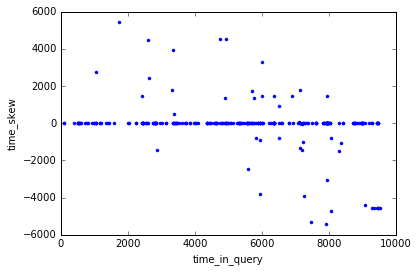

In [31]:
results, query_hashes = match_waveform(y, sr, database, analyzer, matcher, verbose=True)
_ = display_match_alignment(database, query_hashes, results[0, 0])

#query_hashes= 1805 #matching_hashes= 231


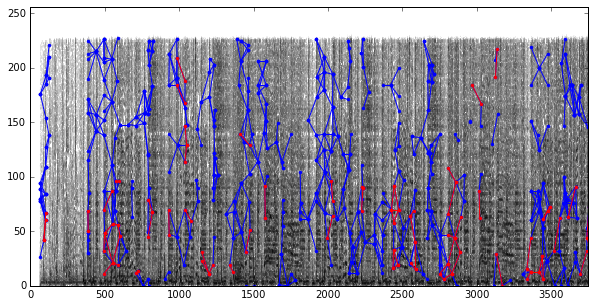

In [32]:
plt.figure(figsize=(10,5))
matching_hashes = display_match_hashes(y, sr, database, query_hashes, results[0, 0], results[0, 2])
xlim([0, frame_rate*60])
ylim([0, 256])
print("#query_hashes=", len(query_hashes), "#matching_hashes=", len(matching_hashes))

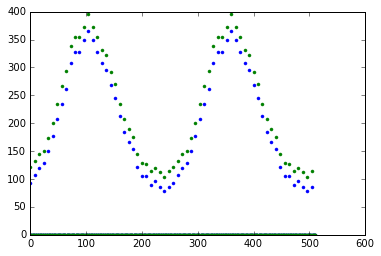

In [30]:
results = np.zeros((512, 2))
for i in xrange(0, 512, 8):
    result, _= match_waveform(np.hstack([np.zeros(i), y]), sr, database, analyzer, matcher)
    results[i] = result[0, [1, 3]]
plot(np.arange(512), results, '.')

In [33]:
# A helper function to run a series of queries.
def generate_random_excerpts(filenames, duration=30.0, wavreadfunction=librosa.load):
    """Read random excerpts from a list of sound files."""
    excerpts = []
    start_times = np.zeros(len(filenames))
    for index, filename in enumerate(filenames):
        y, sr = wavreadfunction(filename)
        file_duration = y.shape[0] / float(sr)
        if file_duration > duration:
            start_point = np.random.rand(1) * (file_duration - duration)
            excerpt = y[int(start_point * sr) : int((start_point + duration) * sr)]
        else:
            # Pad with silence.
            excerpt = np.zeros(int(duration * sr))
            start_point = np.random.rand(1) * (duration - file_duration)
            excerpt[int(start_point * sr) : int(start_point * sr) + y.shape[0]] = y
        start_times[index] = start_point
        excerpts.append(excerpt)
    return np.vstack(excerpts), sr, start_times

wavreadfunction = lambda f : read_mp3_from_url(URL_BASE + '/' + f + '.mp3', sr=None)

ids = [track_name(database, i) for i in xrange(len(database.names))]
query_indices = np.arange(0, 1000, 100)

queries, sr, start_times = generate_random_excerpts([ids[i] for i in query_indices], 
                                                    duration=30.0, wavreadfunction=wavreadfunction)
print(sr, queries.shape)
query_index = 0
print(ids[query_indices[query_index]], start_times[query_index])
result, _= match_waveform(queries[query_index], sr, database, analyzer, matcher)
print("Matched as", track_name(database, result[0, 0]), "at time", result[0, 2] / frame_rate, 
      "with", result[0, 1], "hashes.")
IPython.display.Audio(data=queries[query_index], rate=sr)

16000 (10, 480000)
112/112/01-112_Intro 59.0686002251
Matched as 112/112/01-112_Intro at time 59.104 with 15 hashes.


In [35]:
def eval_fprint(query_waveforms, sr, truth, database, analyzer, matcher, duration=None, snr=None):
    """Run a set of queries through fingerprinting, count number correct."""
    num_queries = len(query_waveforms)
    all_results = np.zeros((num_queries, 4), int)
    for index, query in enumerate(query_waveforms):
        processed_query = query.copy()
        if snr is not None:
            processed_query += np.sqrt(np.mean(query ** 2)) * (10 ** (-snr/20.0)) * np.random.randn(query.shape[0])
        if duration is not None:
            processed_query = processed_query[:int(sr * duration)]
        result, _= match_waveform(processed_query, sr, database, analyzer, matcher)
        if len(result) > 0:
            all_results[index] = result[0][:4]
    print("Correct rate=", "{:.3f}".format(np.mean(all_results[:, 0] == truth)))
    print("Avg matching hashes=", "{:.1f}".format(np.mean(all_results[:, 1].astype(float))))
    return all_results

eval_fprint(queries, sr, query_indices, database, analyzer, matcher, duration=30.0, snr=None)


Correct rate= 1.000
Avg matching hashes= 38.3


array([[   0,   15, 3694,   26],
       [ 100,    6,  -66,    7],
       [ 200,   33,   23,   33],
       [ 300,   97, 7184,  128],
       [ 400,   13, 9904,   15],
       [ 500,  133,  343,  133],
       [ 600,   19, 7756,   20],
       [ 700,   21, 2943,   21],
       [ 800,   16,  382,   17],
       [ 900,   30, 5669,   36]])

In [41]:
result, _ = match_waveform(queries[0] + queries[1], sr, database, analyzer, matcher)
print(result)

[[   0   14 3694   26    0    0    0]]
